# Analyzing the sequencing targets in the Nelson *et al*. 2012 dataset

Daniel P. Rice

28 February 2018

# Introduction

We'd like to use the snp data from Nelson et al. 2012 to demonstrate our two-site frequency spectrum model checking method. In order to use this data, we need to know the number of sites sequenced in each exon target.

The purpose of this notebook is to check data file S1--which contains information about the sequencing targets from the study--for consistency with the data description in the supplemental information.

We'll check the following quantitative statements (page numbers refer to SI):
- "202 genes [were selected]" (p5)
- "The genes selected had [...] coding regions with median of 1,756 [...] bp" (p5)
- "Coding and noncoding exon boundaries were obtained via an Ensembl BioMart query of human genes against NCBI genome build 36.6" (p6)
- "Fifty bases of flanking sequence were added [...]" (p6)
- "[...] covering a total of 863,883 bases." (p6)
- "A total of [...] 351 kb of coding and 323 kb of untranslated (UTR) exons [were targeted]." (Main text p100)
- "Over 93% of target bases were successfully sequenced in at least half of the study samples." (p6)

We'll also sanity-check some other features of the data, including the counts of bases in each of the five categories: coding, UTR, intron, upstream, and downstream.

## Importing the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
targets = pd.read_table('../data/NelsonEtal/S1_targets.txt')
targets.head()

,Gene,Gene37,Chromosome,Exon.NCBI.36.Start,Exon.NCBI.36.Stop,Exon.plus.50.bp.flanking.sequence.NCBI.36.Start,Exon.plus.50.bp.flanking.sequence.NCBI.36.Stop,Entrez.Gene.ID,Transcript,Ensembl.Gene.ID,...,intron,upstream,downstream,code.cover,utr.cover,intron.cover,upstream.cover,downstream.cover,TargetLength,CoverLength
0,ABCB1,ABCB1,7,86970884,86971701,86970834,86971751,5243,NM_000927,ENSG00000085563,...,50,0,50,207,611,50,0,50,918,918
1,ABCB1,ABCB1,7,86973149,86973295,86973099,86973345,5243,NM_000927,ENSG00000085563,...,100,0,0,147,0,100,0,0,247,247
2,ABCB1,ABCB1,7,86976527,86976733,86976477,86976783,5243,NM_000927,ENSG00000085563,...,100,0,0,207,0,100,0,0,307,307
3,ABCB1,ABCB1,7,86982483,86982680,86982433,86982730,5243,NM_000927,ENSG00000085563,...,100,0,0,198,0,100,0,0,298,298
4,ABCB1,ABCB1,7,86983761,86983917,86983711,86983967,5243,NM_000927,ENSG00000085563,...,100,0,0,157,0,100,0,0,257,257


Column definitions are given on p72.

# Consistency with the SI

## Number of genes should be 202

In [3]:
genes = set(targets.Gene)
print('The number of unique gene names =', len(genes))

The number of unique gene names = 202


## The median coding length per gene should be 1,756

In [4]:
targets.groupby('Gene').sum()['code'].describe()

count     202.000000
mean     1738.881188
std      1167.744126
min       294.000000
25%      1061.250000
50%      1401.000000
75%      2173.500000
max      7584.000000
Name: code, dtype: float64

In [5]:
print('The median coding length per gene =', targets.groupby('Gene').sum()['code'].median())

The median coding length per gene = 1401.0


This is 350 bp less than reported.

## 50 basepairs of flanking sequence were added

The flanking region should start 50 bp upstream of the exon:

In [6]:
(targets['Exon.NCBI.36.Start'] - targets['Exon.plus.50.bp.flanking.sequence.NCBI.36.Start']).describe()

count    1989.0
mean       50.0
std         0.0
min        50.0
25%        50.0
50%        50.0
75%        50.0
max        50.0
dtype: float64

This is true for all targets.

The flanking region should stop 50 bp downstream of the exon:

In [7]:
(targets['Exon.plus.50.bp.flanking.sequence.NCBI.36.Stop'] - targets['Exon.NCBI.36.Stop']).describe()

count    1989.000000
mean       73.684766
std       220.405317
min        50.000000
25%        50.000000
50%        50.000000
75%        50.000000
max      6131.000000
dtype: float64

In [8]:
overhang = targets['Exon.plus.50.bp.flanking.sequence.NCBI.36.Stop'] - targets['Exon.NCBI.36.Stop']

In [9]:
np.sum(overhang>50)

129

There are 129 targets where the flanking region stops more than 50bp downstream of the exon.

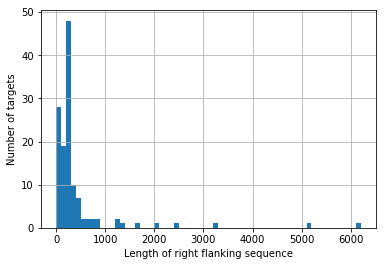

In [10]:
overhang[overhang!=50].hist(bins=np.arange(0,6300,100))
plt.xlabel('Length of right flanking sequence')
plt.ylabel('Number of targets')

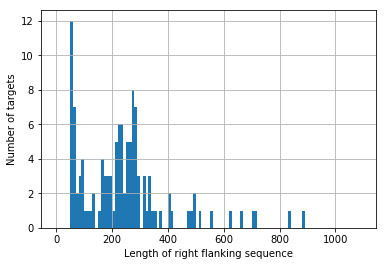

In [11]:
overhang[overhang!=50].hist(bins=np.arange(0,1100,10))
plt.xlabel('Length of right flanking sequence')
plt.ylabel('Number of targets')

The right flanking regions of a few targets are thousands of bp long. Most are distributed bimodally with peaks around ~50bp and ~250bp.

## Total size of regions should be 863,883 bases

We can calculate the total size of the regions two ways:
- using the TargetLength column
- taking the difference between the stop and start bases of the flanking sequence.

In [12]:
targets['TargetLength'].describe()

count    1989.000000
mean      429.665661
std       612.814942
min       106.000000
25%       202.000000
50%       247.000000
75%       335.000000
max      6210.000000
Name: TargetLength, dtype: float64

In [13]:
targets['TargetLength'].sum()

854605

In [14]:
(1 + targets['Exon.plus.50.bp.flanking.sequence.NCBI.36.Stop'] - targets['Exon.plus.50.bp.flanking.sequence.NCBI.36.Start']).describe()

count    1989.000000
mean      429.665661
std       612.814942
min       106.000000
25%       202.000000
50%       247.000000
75%       335.000000
max      6210.000000
dtype: float64

In [15]:
(1 + targets['Exon.plus.50.bp.flanking.sequence.NCBI.36.Stop'] - targets['Exon.plus.50.bp.flanking.sequence.NCBI.36.Start']).sum()

854605

The two methods give the same descriptive statistics (if we add one to the difference between stop and start, which we didn't do when checking the length of the flanking regions.

The total length including the flanking sequences is about 10kb smaller than reported.

## The main text says that there should be 351kb of coding and 323kb of UTR

In [16]:
targets['code'].sum()

351254

In [17]:
targets['utr'].sum()

322917

Both numbers match.

## The covered bases should be >93% of the total bases.

In [18]:
targets['CoverLength'].sum() / targets['TargetLength'].sum()

0.93099736135407585

This checks out. One possibility is that 

## Coding and non-coding boundaries should match Ensembl BioMart query

**TODO**

## Summary

We were able verify:
- "202 genes [were selected]"
- "A total of [...] 351 kb of coding and 323 kb of untranslated (UTR) exons [were targeted]."
- "Over 93% of target bases were successfully sequenced in at least half of the study samples."

and unable to verify:
- "The genes selected had [...] coding regions with median of 1,756 [...] bp" [Actual: 1,401]
- "Fifty bases of flanking sequence were added [...]" [Right flanking regions are greater than 50bp and somtimes much longer] 
- "[...] covering a total of 863,883 bases." [Actual: 854,605]

We have not yet checked:
- "Coding and noncoding exon boundaries were obtained via an Ensembl BioMart query of human genes against NCBI genome build 36.6"

One possible explanation for the disagreement about number of bases and median coding length per gene is that some exons were included in these calculations but excluded from data file S1 for some reason.

# Plausibility/self-consistency checks

## Exon lengths

One possible explanation for the long right flanking region is some miscoding of the exon stop position. This might show up as negative exon lengths:

count    1989.000000
mean      305.980895
std       571.579225
min         6.000000
25%       100.000000
50%       142.000000
75%       215.000000
max      5275.000000
dtype: float64

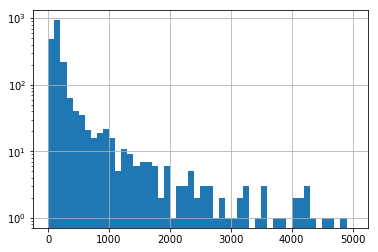

In [19]:
exonlengths = (1 + targets['Exon.NCBI.36.Stop'] - targets['Exon.NCBI.36.Start'])
exonlengths.hist(bins=np.arange(0,5100,100))
plt.yscale('log')
exonlengths.describe()

No exon lengths are negative, but some are very short (min 6bp.)

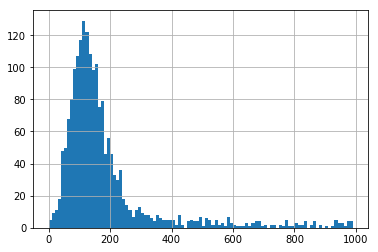

In [20]:
exonlengths.hist(bins=np.arange(0,1000,10))

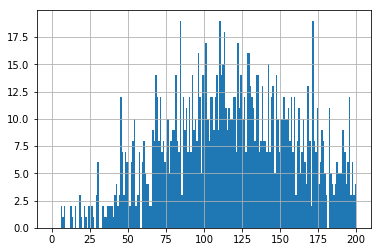

In [21]:
exonlengths.hist(bins=np.arange(0,201,1))

Exon lengths are peaked around 100bp, with a few as short as 6bp.

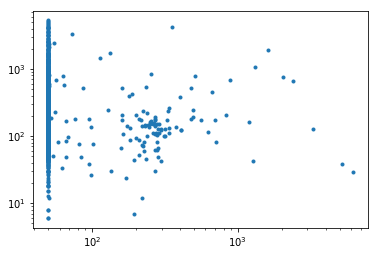

In [22]:
plt.loglog(overhang, exonlengths, '.')

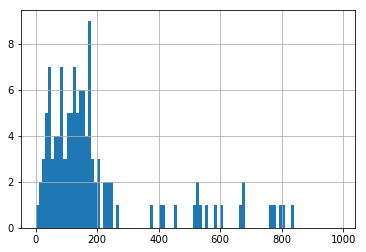

In [23]:
exonlengths[overhang>50].hist(bins=np.arange(0,1000,10))

There's nothing notable about the distribution of exon lengths of exons with right flanking regions longer than 50bp.

## Exon lengths vs. coding and UTR

The table provides the number of bases in each of five categories:
- coding
- utr
- upstream
- downstream
- intron.

My interpretation is that each exon base should be either coding or utr. There should not be coding bases outside of exons.

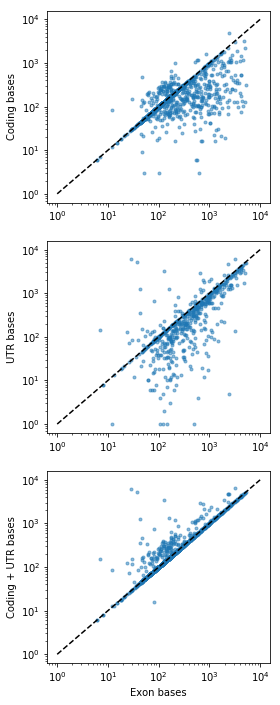

In [24]:
plt.figure(figsize=(4,12))
x = np.logspace(0,4,4)

plt.subplot(311)
plt.loglog(exonlengths, targets['code'], '.', alpha=0.5)
plt.loglog(x,x,'--k')
plt.ylabel('Coding bases')

plt.subplot(312)
plt.loglog(exonlengths, targets['utr'], '.', alpha=0.5)
plt.loglog(x,x,'--k')
plt.ylabel('UTR bases')

plt.subplot(313)
plt.loglog(exonlengths, targets['code'] + targets['utr'], '.', alpha=0.5)
plt.loglog(x,x,'--k')
plt.ylabel('Coding + UTR bases')
plt.xlabel('Exon bases')

In [25]:
(exonlengths - (targets['code'] + targets['utr'])).describe()

count    1989.000000
mean      -32.968829
std       254.457612
min     -6081.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        66.000000
dtype: float64

In [26]:
np.sum((exonlengths - (targets['code'] + targets['utr'])) > 0)

2

In [27]:
np.sum((exonlengths - (targets['code'] + targets['utr'])) < 0)

252

For most targets, the exon length equals the sum of coding and UTR bases. For 2 targets, the exon is longer. For 252 targets, the exon is shorter. This is anomalous.

Maybe there are coding and UTR bases in the flanking regions:

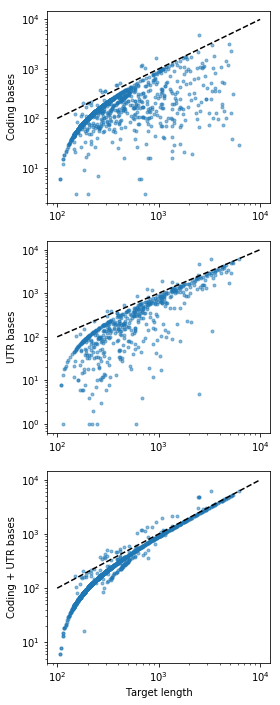

In [28]:
plt.figure(figsize=(4,12))
x = np.logspace(2,4,4)

plt.subplot(311)
plt.loglog(targets['TargetLength'], targets['code'], '.', alpha=0.5)
plt.loglog(x,x,'--k')
plt.ylabel('Coding bases')

plt.subplot(312)
plt.loglog(targets['TargetLength'], targets['utr'], '.', alpha=0.5)
plt.loglog(x,x,'--k')
plt.ylabel('UTR bases')

plt.subplot(313)
plt.loglog(targets['TargetLength'], targets['code'] + targets['utr'], '.', alpha=0.5)
plt.loglog(x,x,'--k')
plt.ylabel('Coding + UTR bases')
plt.xlabel('Target length')

The curve away from the 1-1 line is because the target length is usually 100 bp longer than the exon. However, there are still targets where the coding plus UTR base count is larger than the coding length.

In [29]:
(targets['TargetLength'] - (targets['code'] + targets['utr'])).describe()

count    1989.000000
mean       90.715938
std       131.555304
min     -3080.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       430.000000
dtype: float64

In [30]:
(targets['TargetLength'] < (targets['code'] + targets['utr'])).sum()

38

There are 38 such targets.

In [31]:
(exonlengths < (targets['code'] + targets['utr'])).sum()

252

In [32]:
exon_mismatch_genes = set(targets[(exonlengths < (targets['code'] + targets['utr']))]['Gene'])
print(exon_mismatch_genes, len(exon_mismatch_genes))

{'MME', 'PSEN2', 'NFKBIL1', 'SIRT2', 'ZAP70', 'KCNN4', 'PTGER1', 'IL28B', 'GLP1R', 'SIRT6', 'HCRTR1', 'PRKAG1', 'CCR9', 'GRIN2B', 'RORC', 'CCR5', 'ITGA4', 'LRRK2', 'MMP12', 'SCD', 'TNFSF11', 'CCL7', 'APH1B', 'CHRM3', 'CHRNA5', 'KCNMA1', 'CD3E', 'CAMKK2', 'SYK', 'APH1A', 'MIF', 'SIRT7', 'GSK3B', 'SIRT5', 'DYRK3', 'GPR109A', 'CACNA1B', 'HCRTR2', 'CCR3', 'P4HA2', 'TRPC3', 'SLC10A1', 'IL6', 'JAK3', 'OPRM1', 'APCS', 'OXTR', 'APP', 'P2RX7', 'MAG', 'CCL8', 'BRD4', 'CD3D', 'SIRT3', 'IL7R', 'GABRA3', 'KIAA1967', 'DPP4', 'CXCL3', 'TRPV1', 'CDH2', 'MMP9', 'PDE4A', 'PSEN1', 'CHRNB2', 'SP110', 'GRIN1', 'OSM', 'MAPK14', 'TACR1', 'ADIPOQ', 'BDKRB2', 'HTR4', 'IL18', 'RORA', 'SLC6A9', 'CHRNA6', 'GABRA2', 'TBXA2R', 'MAPK11', 'CD3G', 'P4HA1', 'GHSR', 'PDE5A', 'STIM1', 'ITGB1', 'MS4A1', 'PTHR1', 'NTRK2', 'FAAH', 'CHRNA3', 'NOS2A', 'NRXN1', 'CHRM4', 'ELA2', 'SLC6A4', 'PGK1', 'TNNI3K', 'DPP3', 'HTR2C', 'CYSLTR1', 'EDG1', 'BICD1', 'CTSK', 'GPBAR1', 'DRD2', 'ADORA1', 'CHRNA7', 'HRH1', 'IL23A', 'CXCL5', 'PTGIR

There are 252 targets where coding + UTR bases is longer than the exon length. They are in 136 genes.

## Upstream and downstream regions

My understanding is that upstream and downstream regions are 50bp flanking regions that are upstream or downstream of the gene. If so, there should be 50bp of each per gene.

In [33]:
ud_bygene = targets.groupby('Gene').sum()
ud_bygene[['upstream', 'downstream']].describe()

,upstream,downstream
count,202.000000,202.000000
mean,46.247525,46.866337
std,12.802678,9.214252
min,0.000000,0.000000
25%,50.000000,49.000000
50%,50.000000,50.000000
75%,50.000000,50.000000
max,50.000000,51.000000


In [34]:
ud_bygene[ud_bygene.downstream>50]

,Exon.NCBI.36.Start,Exon.NCBI.36.Stop,Exon.plus.50.bp.flanking.sequence.NCBI.36.Start,Exon.plus.50.bp.flanking.sequence.NCBI.36.Stop,Entrez.Gene.ID,code,utr,intron,upstream,downstream,code.cover,utr.cover,intron.cover,upstream.cover,downstream.cover,TargetLength,CoverLength
Gene,,,,,,,,,,,,,,,,,
IL6,136406984,136408491,136406684,136408805,21414,639,887,500,50,51,639,808,500,50,0,2127,1997


This appears to be mostly correct, although there are some genes with less than 50 bp of either and one gene with more than 50bp of downstream.

Here are some distributions of upstream and downstream lengths:

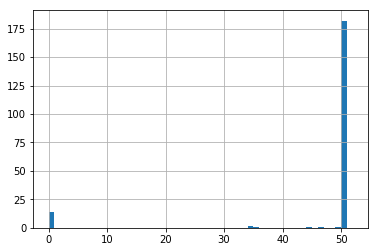

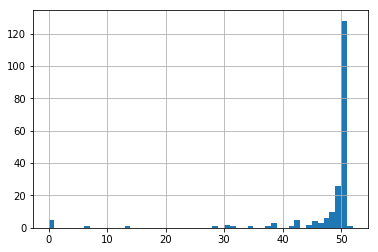

In [35]:
ud_bygene.upstream.hist(bins=np.arange(0,53,1))
plt.show()
ud_bygene.downstream.hist(bins=np.arange(0,53,1))

And distributions by target rather than gene:

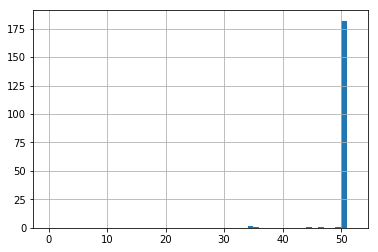

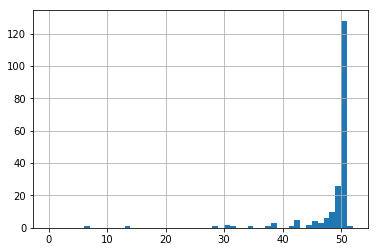

In [36]:
targets.upstream[targets.upstream>0].hist(bins=np.arange(0,53,1))
plt.show()
targets.downstream[targets.downstream>0].hist(bins=np.arange(0,53,1))

In [37]:
np.sum((targets.downstream > 0) & (targets.upstream > 0))

6

Six targets have both upstream and downstream regions:

In [38]:
targets[(targets.downstream > 0) & (targets.upstream > 0)]

,Gene,Gene37,Chromosome,Exon.NCBI.36.Start,Exon.NCBI.36.Stop,Exon.plus.50.bp.flanking.sequence.NCBI.36.Start,Exon.plus.50.bp.flanking.sequence.NCBI.36.Stop,Entrez.Gene.ID,Transcript,Ensembl.Gene.ID,...,intron,upstream,downstream,code.cover,utr.cover,intron.cover,upstream.cover,downstream.cover,TargetLength,CoverLength
323,CHRM4,CHRM4,11,46363224,46364734,46363174,46364784,1132,NM_000741,ENSG00000222006,...,0,50,42,1420,79,0,50,42,1611,1591
436,CYSLTR2,CYSLTR2,13,48178952,48181499,48178902,48181549,57105,NM_020377,ENSG00000152207,...,0,50,50,1041,1507,0,50,50,2648,2648
604,GPR119,GPR119,X,129346095,129347102,129346045,129347152,139760,NM_178471,ENSG00000147262,...,0,50,50,1008,0,0,50,50,1108,1108
689,HTR1A,HTR1A,5,63292034,63293302,63291984,63293352,3350,NM_000524,ENSG00000178394,...,0,50,50,1269,0,0,50,50,1369,1369
690,HTR1B,HTR1B,6,78228641,78229900,78228591,78229950,3351,NM_000863,ENSG00000135312,...,0,50,50,1173,87,0,50,50,1360,1360
1977,UTS2R,UTS2R,17,77925490,77926659,77925440,77926709,2837,NM_018949,ENSG00000181408,...,0,50,50,490,0,0,50,0,1270,540


Are they the only targets in those genes?

In [39]:
ud_genes = targets[(targets.downstream > 0) & (targets.upstream > 0)]['Gene']
targets[targets.Gene.isin(ud_genes)]

,Gene,Gene37,Chromosome,Exon.NCBI.36.Start,Exon.NCBI.36.Stop,Exon.plus.50.bp.flanking.sequence.NCBI.36.Start,Exon.plus.50.bp.flanking.sequence.NCBI.36.Stop,Entrez.Gene.ID,Transcript,Ensembl.Gene.ID,...,intron,upstream,downstream,code.cover,utr.cover,intron.cover,upstream.cover,downstream.cover,TargetLength,CoverLength
323,CHRM4,CHRM4,11,46363224,46364734,46363174,46364784,1132,NM_000741,ENSG00000222006,...,0,50,42,1420,79,0,50,42,1611,1591
436,CYSLTR2,CYSLTR2,13,48178952,48181499,48178902,48181549,57105,NM_020377,ENSG00000152207,...,0,50,50,1041,1507,0,50,50,2648,2648
604,GPR119,GPR119,X,129346095,129347102,129346045,129347152,139760,NM_178471,ENSG00000147262,...,0,50,50,1008,0,0,50,50,1108,1108
689,HTR1A,HTR1A,5,63292034,63293302,63291984,63293352,3350,NM_000524,ENSG00000178394,...,0,50,50,1269,0,0,50,50,1369,1369
690,HTR1B,HTR1B,6,78228641,78229900,78228591,78229950,3351,NM_000863,ENSG00000135312,...,0,50,50,1173,87,0,50,50,1360,1360
1977,UTS2R,UTS2R,17,77925490,77926659,77925440,77926709,2837,NM_018949,ENSG00000181408,...,0,50,50,490,0,0,50,0,1270,540


Yes. This supports my interpretation of the upstream and downstream categories.

## Introns

If the flanking regions that are not upstream or downstream are introns, we'd expect most targets to have 100bp of intronic sequence, and a smaller number to have 50bp.

In [40]:
targets.intron.describe()

count    1989.000000
mean       81.259427
std       135.118995
min     -3128.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       430.000000
Name: intron, dtype: float64

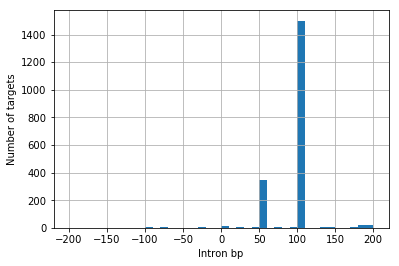

In [41]:
targets.intron.hist(bins=np.arange(-200,210,10))
plt.ylabel('Number of targets')
plt.xlabel('Intron bp')

We do see peaks at 50bp and 100bp, as expected. However, we also see some targets with negative intron bp, which should not be possible.

In [42]:
np.sum(targets.intron<0)

40

In [43]:
negative_intron_genes = set(targets[targets.intron<0]['Gene'])
print(negative_intron_genes, len(negative_intron_genes))

{'GRIN1', 'SIRT5', 'MAPK14', 'TACR1', 'DYRK3', 'HTR4', 'SIRT2', 'BICD1', 'ZAP70', 'GPBAR1', 'SLC10A1', 'TBXA2R', 'OPRM1', 'PRKAG1', 'MAG', 'CCR9', 'NR1D1', 'DRD3', 'GHSR', 'PTGS1', 'ITGB1', 'SIRT3', 'NTRK2', 'KCNMA1', 'CAMKK2', 'APH1A', 'PPARD', 'RTN4', 'PDE5A', 'EDNRB'} 30


In [44]:
len(negative_intron_genes.intersection(exon_mismatch_genes))

30

There are 40 such sites in 30 genes. All 30 genes belong to the set with exon lengths that don't match the coding + UTR bases.

One possibility, given our observations about excess coding and UTR bases is that the intron category was calculated by subtracting the other categories from TargetLength:

In [45]:
(targets.TargetLength - (targets.code + targets.utr + targets.upstream + targets.downstream + targets.intron)).describe()

count    1989.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

In fact, the TargetLength column is the sum of all five catories, which supports this interpretation.

# Conclusions

I've identified 4 types of inconsistencies in supplimentary data file S1:
1. There are fewer total bases in targets and fewer coding bases per gene than reported in the SI.
2. The right flanking region of some targets extends more than 50bp beyond the exon stop position.
3. For some targets, the number of coding and UTR bases excedes the exon length and even the target length.
4. For some targets, the number of intron bases is negative.

The first inconsistency could be due to file S1 excluding some targets that were used to calculate the numbers reported in the SI. The second could be due to either an error in identifying exons, or the fact that some targets truly extend beyond 50bp past the exon for an unknown reason.

The third and fourth inconsistencies are potentially more problematic. I believe that either: (1) coding and UTR bases are not mutually exclusive, (2) these bases were misidentified/misreported, or (3) the target regions were misreported. In any case, the negative values for intron bases are an error. A further complication is that the total number of coding and UTR bases match the numbers reported in the main text.

The next step will be to compare the exon start positions with an Ensembl BioMart query to check consistency with that database.